<a href="https://colab.research.google.com/github/prashantiyaramareddy/MyPython-Stuff/blob/master/Pytorch/Pytorch_Image_Transformer_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Pytorch paper - Vision Transformer



## 0. Get Setup


In [1]:
# For notebook to run with updated API's, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[0]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/cu118
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it does not work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from github if it does not work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going modular scripts
  print("[INFO] Couldn't find going_modular or helperfunctions scripts... downloading them from github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep_learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helperfunctions scripts... downloading them from github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 37.46 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


### 1. Get Data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
### 2. Create Datasets and DataLoaders

## 2.1 Prepare transforms for images
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
## 2.2 Turn image into DataLoader's
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b66212df410>,
 ['pizza', 'steak', 'sushi'])

In [7]:
## 2.3 Visualize a single image

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(0))

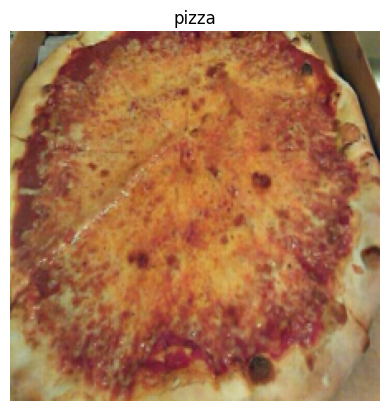

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 4.1 Calculate patch embedding input and output shapes


In [9]:
height = 224
width  = 224
color_channels = 3
patch_size = 16

# Calculate N (number of patches)
number_of_patches = (height * width) / (patch_size * patch_size)
print(f"Number of patches: {number_of_patches}")

Number of patches: 196.0


* Input: The image starts as 2D with size ${H \times W \times C}$.
* Output: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [10]:
# Input Shape ( this is the size of single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196.0, 768))

### 4.2 Turning single image into patches


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

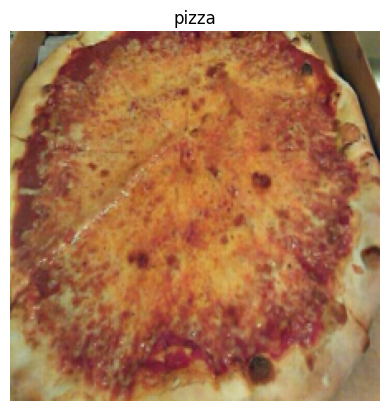

In [11]:
# View  a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [12]:
image.shape

torch.Size([3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(15.5), np.float64(-0.5))

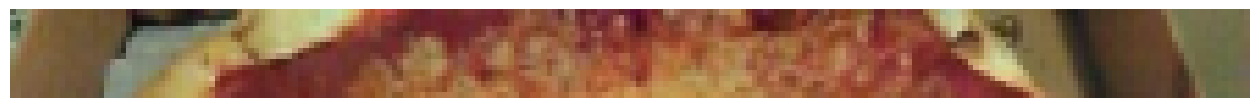

In [13]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert the image into color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:, :])
plt.axis(False)

Number of patches: 14.0


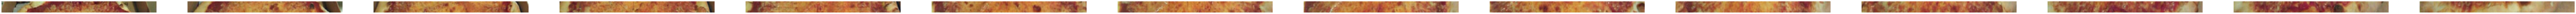

In [14]:
# Set up code to plot top row as patches
img_size = 224
patch_size = 16
number_of_patches = img_size/patch_size
print(f"Number of patches: {number_of_patches}")
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of sub plots
fig, axs = plt.subplots(nrows= 1,
                        ncols= img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(img_size, img_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].axis(False)

In [ ]:
import matplotlib.pyplot as plt


# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches: {num_patches}\
      \nNumber of rows: {num_patches}\
      \nNumber of columns: {num_patches}\
      \nImage size: {img_size}\
      \nPatch size: {patch_size}\
      \nTotal Patches : {num_patches ** 2}")

# Create a series of patches
fig, axs = plt.subplots(nrows= int(num_patches),
                        ncols= int(num_patches),
                        sharex=True,
                        sharey=True,
                        figsize=(img_size, img_size))

# Loop through height and width of image
for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_row:patch_row+patch_size, patch_col:patch_col+patch_size])
    axs[i, j].set_ylabel(i+1,
                         rotation = "horizontal",
                         horizontalalignment = "right",
                         verticalalignment = "center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].axis(False)
    axs[i, j].label_outer()

Number of patches: 14.0      
Number of rows: 14.0      
Number of columns: 14.0      
Image size: 224      
Patch size: 16      
Total Patches : 196.0


### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using 'torch.nn.Conv2d' layer and setting kernel size and stride nn.parameter to 'patch_size'

In [ ]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

In [ ]:
# View Single Image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

Now we have passed our single image to out 'conv2d' layer, it's shape is :

```python
torch.Size([1, 768, 14, 14])
```

In [ ]:
image_out_of_conv.requires_grad

In [ ]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Random indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        sharex=True,
                        sharey=True,
                        figsize=(15, 5))
# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[0, idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set_title(f"Feature Map {idx+1}")
  axs[i].axis(False)

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad, single_feature_map.shape

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we got a series of convolutional feature maps(patch embeddings that we want to flatten into a sequence of patch embeddings to satisfy the criteria of the ViT Transformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
flatten_layer(image_out_of_conv).shape

In [ ]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into features
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
print(f"Image shape after conv2d layer: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_flatten = flatten_layer(image_out_of_conv)
print(f"Image shape after flatten layer: {image_out_of_flatten.shape}")

In [ ]:
# Rearrange output of lfattened layer
image_out_of_flatten = image_out_of_flatten.permute(0, 2, 1)
print(f"{image_out_of_flatten.shape} -> (batch_size, number_of_patches, embedding_dim)")

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_flatten[:, :, 0]
single_flattened_feature_map, single_flattened_feature_map.shape

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False)

In [ ]:
# Check the shape of the tensor after flattening and permuting
print(f"Shape of image_out_of_flatten after flattening and permuting: {image_out_of_flatten.shape}")

### 4.5 Turning the ViT patch embedding layer into a Pytorch module

We want this module to do a few things
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embeddings dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define ` forward()` that defines the forward computation (e.g., pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [ ]:
# 1. Create a class called Patch Embedding
class PatchEmbedding(nn.Module):
  #2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels: int = 3,
               embedding_dim: int = 768,
               patch_size: int = 16):
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    self.embedding_dim = embedding_dim
    self.patch_size = patch_size

  #3. Create a layer to turn an image into embedding patches using nn.Conv2d()
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Image size must be divisible by patch size, image shape : {image_resolution}, patch size: {self.patch_size}"
    # Pass image through convolutional layer
    x_out = self.patcher(x)
    x_out = self.flatten(x_out)
    x_out = x_out.permute(0, 2, 1)
    return x_out


set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=768,
                          patch_size=16)
# Pass a single image through patch embedding layer
print(f"Input shape: {image.shape}")
print(f"Output shape: {patchify(image.unsqueeze(dim=0)).shape}")
print(f"Output patch embedding sequence shape : {patchify(image.unsqueeze(dim=0))[:, :, 0]}")

In [ ]:
rand_image_tensor = torch.randn(1,3,224, 224)
rand_image_tensor_bad = torch.randn(1,3,229, 229)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patchify(rand_image_tensor).shape}")

### 4.6 Creating the class token embedding
Want to : prepend a learnable class token to the start of the patch embedding

In [ ]:
patch_embedded_image = patchify(image.unsqueeze(dim=0))
patch_embedded_image

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[2]
batch_size, embedding_dim

In [ ]:
# Create a class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
patch_embedded_image_with_class_embedding

### 4.7 Creating the position embedding
Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

In [ ]:
# Calculate the N ( number of patches)
number_of_patches = int((height * width) / (patch_size * patch_size))

# Get the embedding dimension
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,      embedding_dim),
                                  requires_grad=True)
position_embedding


In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")

### 4.8 Putting it all together : from image to embedding
We've written code to turn a single image into a sequence of patch embeddings.
Lets write in one cell

In [ ]:
# Set seeds
set_seeds()
# 1. Set Patch size
patch_size = 16

# 2. Print shapes of original tensor shape and get the image dimensions
print(f"Image tensor shape: {image.shape}")
image_resolution = image.shape[-1]
print(f"Image resolution: {image_resolution}")

# 3. Get the image tensor and add a batch dimension
image_tensor = image.unsqueeze(dim=0)
print(f"Image tensor shape: {image_tensor.shape}")

# 4. Create a patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=768,
                          patch_size=patch_size)
print(f"Patch embedding layer: {patchify}")

# 5. Pass input image through Patch Embedding LAyer
patch_embedded_image = patchify(image_tensor)
print(f"Shape of patch embedded image: {patch_embedded_image.shape}")

# 6. Create a class token embeddings
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[2]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)

# 7. Prepend the class token embedding to the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(f"Shape of patch embedded image with class embedding: {patch_embedded_image_with_class_embedding.shape}")

# 8. Create patch position embedding
number_of_patches = int((image_resolution * image_resolution) / (patch_size * patch_size))
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,      embedding_dim),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with the class token
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")

## Equation 2: Multi head self attention

* Multi head self attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in Pytorch we can use https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = Layer Normalization(LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In Pytorch - https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html normalizes values over $D$ dimension, in our case, the $D$ is the embedding dimension.
    * When we normalize along the embedding dimension,it's like making all of the stairs in a staircase the same size.
    


In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """ Creates a multi-head self-attention block ("MSA block" for short)
  """
  def __init__(self,
             embedding_dim:int=768, # Hidden size D (embedding dimension) from Table
             num_heads:int = 12, # Heads from Table 1 for ViT Base
             attn_dropout:int = 0 # Dropout from Table 1 for ViT Base
             ):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead self attention(MSA) layer
    self.multihead_self_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         dropout=attn_dropout)
        #is the batch first? (batch,number_of_patches, embedding_dimenstion)
  def forward(self, x):
    x = self.layer_norm(x)
    x, _ = self.multihead_self_attention(query=x,
                                    key=x,
                                    value=x)
    return x

In [ ]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                            num_heads=12,
                                                            attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA Block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Shape of patched image through MSA block: {patched_image_through_msa_block.shape}")
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")



### Equation 3 : MLP Block
* **MLP** = The MLP contains two layers with a GELU non- linearity (section 3.1)
  * MLP = a quite broad term for a block with a series of layers, layers can be multiple or even only one hidden layer.
  * Layers can mean: fully connected, dense, linear, feed forward, all are often similar names for the same thing. In Pytorch, they have often called torch.nn.Linear() and in TensorFlow they might be called tf.keras.layers.Dense()
  * GELU in Pytorch - https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * **Dropout** = Dropout, when used, is applied after every dense layer except for the qkv- projections and directly after adding positional - to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.

  In pseudocode:
  ```python
  # MLP
  x = linear -> non-linear -> dropout ->linear -> dropout
  ```
  


In [ ]:
class MLPBlock(nn.Module):
  """Creates a multi-layer perceptron block
  """
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p=dropout)

    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
# Create an instance of MLP Block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# Pass the output of the MSA block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(f"Shape of patched image through MLP block: {patched_image_through_mlp_block.shape}")

## 7. Creating the Transformer encoder

The Transformer Encoder is a combination of MSA and MLP block

And there are residual connections between each block


*   Encoder = turn a sequence into learnable representation

*   Decoder = go from learn representation back to some sort of sequence

* Residual connections = add a layer(s) input to it's subsequent output, this enables the creation of deeper networks ( prevents weights from getting too small)

``` python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_input + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...





In [ ]:
class TransformerEncoderBlock(nn.Module):
  """Creates a single transformer encoder block
  """
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=307,
               attn_dropout:float=0.1,
               mlp_dropout:float=0.1):
    super().__init__()

    # Create the MSA block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    # Create the MLP block

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x)
    x_skip_connection = x
    x = self.mlp_block(x)
    x = x + x_skip_connection
    return x




In [ ]:
# Create an instance of transformer encoder block
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names  = ["input_size", "output_size", "num_params", "trainable"],
        col_width  = 20,
        row_settings = ["var_names"]
        )

In [ ]:
### 7.1 Create a custom Transformer encoder layer with inbuilt Pytorch layers same as above with torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                            nhead=12,
                                                            dim_feedforward=3072,
                                                            dropout=0.1,
                                                            activation='gelu',
                                                            batch_first=True,
                                                            norm_first=True)


torch_transformer_encoder_layer



In [ ]:
# Get a summary using torchinfo.summary
summary(model = torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names  = ["input_size", "output_size", "num_params", "trainable"],
        col_width  = 20,
        row_settings = ["var_names"]
        )

In [ ]:
### 8.1 Putting all together to create a ViT class

# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
  """ Creates a Vision Transformer architecture with ViT base hyperparameters by default. """
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000):
    super().__init__()

    # 3. Make the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    # 4. Calculate the number of patches (height*width/patch^2)
    self.num_patches = (img_size // patch_size) ** 2

    # 5. Create learnable class embedding (needs to go at the front of the sequence of patch embeddings)
    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                         requires_grad=True)

    # 6. Create learnable position embedding
    self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches+1,
                                                       embedding_dim),requires_grad=True)
    # 7. Create the embedding drop out value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. Create the patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          embedding_dim=embedding_dim,
                                          patch_size=patch_size)

    # 9. Create Transformer encoder blocks ( we can stack Transformer Encoder blocks using nn.Sequential)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                   num_heads=num_heads,
                                                                   mlp_size=mlp_size,
                                                                   attn_dropout=attn_dropout,
                                                                   mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # 10. Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  # 11. Create a forward() method
  def forward(self, x):

    # 12. Get batch size
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # 14. Pass image through patch embedding layer
    x = self.patch_embedding(x)

    # 15. Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)

    # 16. Add position embedding to patch embedding
    x = x + self.position_embedding

    # 17. Run embedding dropout
    x = self.embedding_dropout(x)

    # 18. Run the transformer encoder
    x = self.transformer_encoder(x)

    # 19. Put 0 index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    # 20. Return output
    return x

In [ ]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data = torch.randn(1, 1, 768), requires_grad=True)
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Class token embedding single: {class_token_embedding_single.shape}")
print(f"Class token embedding expanded: {class_token_embedding_expanded.shape}")


In [ ]:
# Test the ViT class
set_seeds()

# Create a random tensor with same shape as a single image
rand_image_tensor = torch.randn(1,3,224, 224)

# Create an instance of the ViT class
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(rand_image_tensor)

In [ ]:
### 8.1 Getting a visual summary of our ViT model

from torchinfo import summary

summary(model = vit,
        input_size = (1, 3, 224, 224),
        col_names  = ["input_size", "output_size", "num_params", "trainable"],
        col_width  = 20,
        row_settings = ["var_names"]
        )

### Training ViT Model



In [ ]:
# We will start by importing `engine.py` script from `going_modular.going_modular` then we will set up the optimizer

from going_modular.going_modular import engine
import torch

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas = (0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0.1,
                             amsgrad=False)

# Set up loss function for multi- class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Move model to device
vit.to(device)

# Train the model and save the training results to a dictionary
vit_training_results = engine.train(model=vit,
                                     train_dataloader=train_dataloader,
                                     test_dataloader=test_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs = 10,
                                    device=device)